## 여러 정리되지 않은 생각들
- 변수들의 n차식 그리고 서로 곱(나누는)는 비선형으로 한번해보기
- 혈압 처방을 받았다면 혈압을 통제하고 있을건데 그러면 몸무게나 다른 팩트들도 정상화 되나?
- 그냥 혈압만 약에대해 통제된다 했을때 국민건강보험공단 데이터에서 고혈압 환자들을 어떻게 구분할까? : 일단, 고협압 환자들이 거의 없을꺼같은 젊은층에서 모델링
- 근데또 혈압은 나이에 따라 (몸무게도 마찬가지) 달라지는데... 
- plt.savefig('filename.png')


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [375]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import time

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

## I.데이터 불러오기&전처리

In [235]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [236]:
# !ls -l '/content/drive/MyDrive/Colab Notebooks/datasets/health_care/NHIS_OPEN_GJ_2017_v1.1.csv'

-rw------- 1 root root 108444299 Oct  7 01:05 '/content/drive/MyDrive/Colab Notebooks/datasets/health_care/NHIS_OPEN_GJ_2017_v1.1.csv'


In [506]:
# DF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/health_care/NHIS_OPEN_GJ_2017_v1.1.csv', encoding='cp949')
DF = pd.read_csv('c:/My_data/health_care/NHIS_OPEN_GJ_2017_v1.1.csv', encoding='cp949')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   기준년도          1000000 non-null  int64  
 1   가입자일련번호       1000000 non-null  int64  
 2   성별코드          1000000 non-null  int64  
 3   연령대코드(5세단위)   1000000 non-null  int64  
 4   시도코드          1000000 non-null  int64  
 5   신장(5Cm단위)     1000000 non-null  int64  
 6   체중(5Kg단위)     1000000 non-null  int64  
 7   허리둘레          999734 non-null   float64
 8   시력(좌)         999817 non-null   float64
 9   시력(우)         999811 non-null   float64
 10  청력(좌)         999842 non-null   float64
 11  청력(우)         999844 non-null   float64
 12  수축기혈압         999981 non-null   float64
 13  이완기혈압         999982 non-null   float64
 14  식전혈당(공복혈당)    999958 non-null   float64
 15  총콜레스테롤        999957 non-null   float64
 16  트리글리세라이드      999955 non-null   float64
 17  HDL콜레스테롤      999956 non-nul

In [507]:
# null 값 확인
DF.isnull().sum()

기준년도                  0
가입자일련번호               0
성별코드                  0
연령대코드(5세단위)           0
시도코드                  0
신장(5Cm단위)             0
체중(5Kg단위)             0
허리둘레                266
시력(좌)               183
시력(우)               189
청력(좌)               158
청력(우)               156
수축기혈압                19
이완기혈압                18
식전혈당(공복혈당)           42
총콜레스테롤               43
트리글리세라이드             45
HDL콜레스테롤             44
LDL콜레스테롤           2912
혈색소                  52
요단백                4592
혈청크레아티닌              43
(혈청지오티)AST           41
(혈청지오티)ALT           42
감마지티피                42
흡연상태                144
음주여부                536
구강검진수검여부              0
치아우식증유무         1000000
결손치유무           1000000
치아마모증유무         1000000
제3대구치(사랑니)이상    1000000
치석               621422
데이터공개일자               0
dtype: int64

In [508]:
# 열 삭제하기 (시력)(청력)(구강건강관련) ,기준년도,가입자일년번호, 데이터공개일자, *일단=(혈청지오티)AST 등4개

DF = DF.drop(columns=['기준년도','가입자일련번호','시력(좌)','시력(우)','청력(좌)','청력(우)','구강검진수검여부','치아우식증유무','결손치유무','치아마모증유무','제3대구치(사랑니)이상','치석','데이터공개일자','(혈청지오티)AST','(혈청지오티)ALT','감마지티피'])

In [509]:
#결측치 제거
DF.dropna(inplace = True)

In [510]:
# 음주여부 Y=1,N=0
DF = DF.replace({'Y':1.0,'N':0.0})

In [511]:
# 변수명 정의
sex = DF['성별코드']
age = DF['연령대코드(5세단위)']
city = DF['시도코드']
ht = DF['신장(5Cm단위)']
wt = DF['체중(5Kg단위)']
waist = DF['허리둘레']
sbp = DF['수축기혈압']
dbp = DF['이완기혈압']
fbs = DF['식전혈당(공복혈당)']
tchol = DF['총콜레스테롤']
tg = DF['트리글리세라이드']
hdl = DF['HDL콜레스테롤']
ldl = DF['LDL콜레스테롤']
hgb = DF['혈색소']
upro = DF['요단백']
cr = DF['혈청크레아티닌']
smoking = DF['흡연상태']
alcohol = DF['음주여부']

In [512]:
# 데이터 프레임 변수명 전환
DF = DF.rename(columns={'성별코드':'sex', '연령대코드(5세단위)':'age','시도코드':'city','신장(5Cm단위)':'ht','체중(5Kg단위)':'wt','허리둘레':'waist','수축기혈압':'sbp','이완기혈압':'dbp','식전혈당(공복혈당)':'fbs','총콜레스테롤':'tchol','트리글리세라이드':'tg','HDL콜레스테롤':'hdl','LDL콜레스테롤':'ldl','혈색소':'hgb','요단백':'upro','혈청크레아티닌':'cr','흡연상태':'smoking','음주여부':'alcohol'})

In [513]:
# 정수 실수로 전환
DF['sex'] = pd.to_numeric(DF['sex'], downcast='float')
DF['age'] = pd.to_numeric(DF['age'], downcast='float')
DF['city'] = pd.to_numeric(DF['city'], downcast='float')
DF['ht'] = pd.to_numeric(DF['ht'], downcast='float')
DF['wt'] = pd.to_numeric(DF['wt'], downcast='float')
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991608 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      991608 non-null  float32
 1   age      991608 non-null  float32
 2   city     991608 non-null  float32
 3   ht       991608 non-null  float32
 4   wt       991608 non-null  float32
 5   waist    991608 non-null  float64
 6   sbp      991608 non-null  float64
 7   dbp      991608 non-null  float64
 8   fbs      991608 non-null  float64
 9   tchol    991608 non-null  float64
 10  tg       991608 non-null  float64
 11  hdl      991608 non-null  float64
 12  ldl      991608 non-null  float64
 13  hgb      991608 non-null  float64
 14  upro     991608 non-null  float64
 15  cr       991608 non-null  float64
 16  smoking  991608 non-null  float64
 17  alcohol  991608 non-null  float64
dtypes: float32(5), float64(13)
memory usage: 124.8 MB


In [514]:
#시간이 너무 많이 걸림
# sns.pairplot(DF)  
# plt.show()

In [515]:
fbs.describe()

count    991608.000000
mean        100.424266
std          24.178758
min          25.000000
25%          88.000000
50%          96.000000
75%         105.000000
max         852.000000
Name: 식전혈당(공복혈당), dtype: float64

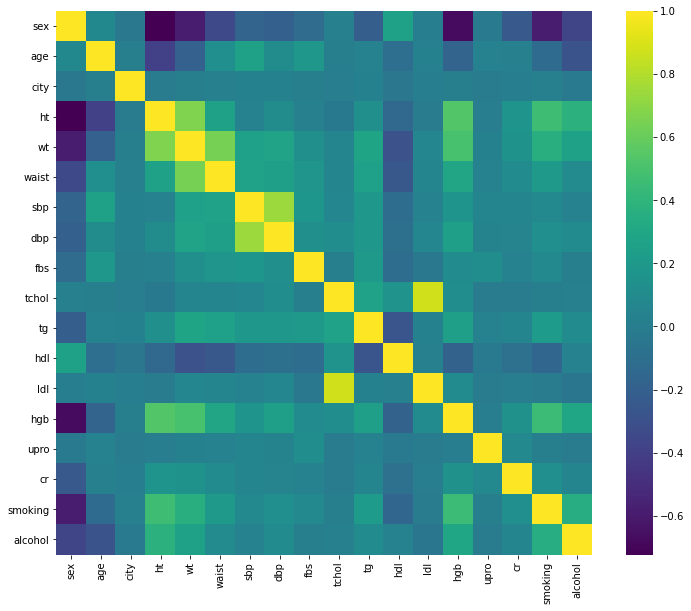

In [516]:
#전체 상관계수 분포
plt.figure(figsize=(12,10))
corr = DF.corr()
sns.heatmap(corr, cmap='viridis')
plt.savefig('heatmap.png')
plt.show()

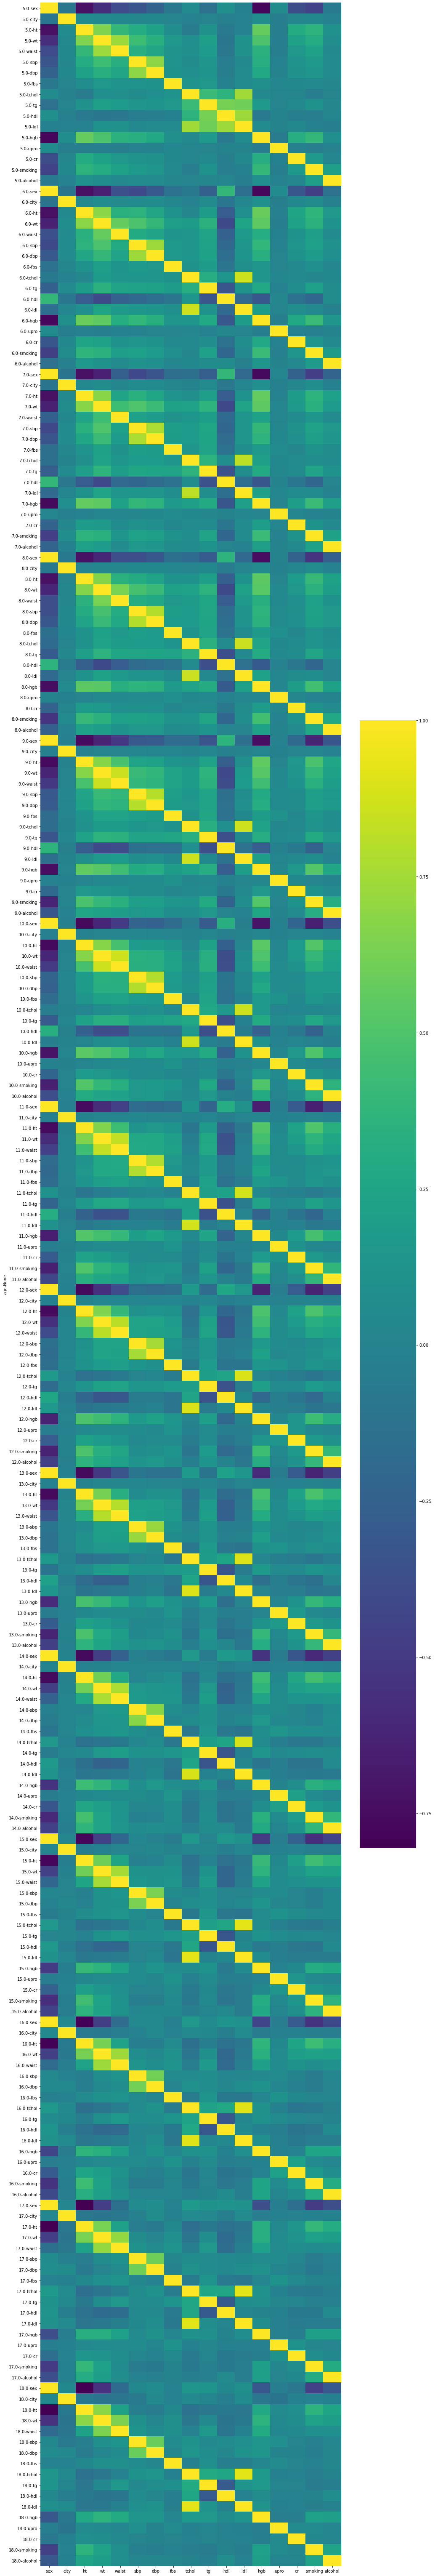

In [517]:
# 연령대별로 groupby
plt.figure(figsize=(16,112))
corr_age = DF.groupby('age').corr()
sns.heatmap(corr_age, cmap='viridis')
plt.show()

## II.데이터 전처리


### 1) bmi, absi 추가하기

In [518]:
# 추가 해야 할 항목들 bmi, absi (A Body Shape Index)
DF['bmi'] = DF['wt']/((DF['ht']/100)**2)
DF['absi'] = (DF['waist']*0.3937)/((DF['bmi']**(2/3))*((DF['ht']/100)**(1/2)))

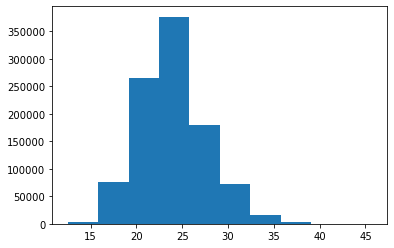

In [519]:
# bmi 분포 확인하기
plt.hist(DF['bmi'])
plt.show()

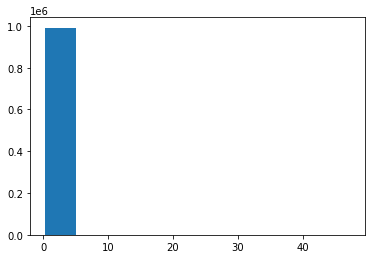

In [520]:
# absi 분포 확인하기
plt.hist(DF['absi'])
plt.show()

- absi 이상데이터 확인 
- 대략 5이상 불가

In [521]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991608 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      991608 non-null  float32
 1   age      991608 non-null  float32
 2   city     991608 non-null  float32
 3   ht       991608 non-null  float32
 4   wt       991608 non-null  float32
 5   waist    991608 non-null  float64
 6   sbp      991608 non-null  float64
 7   dbp      991608 non-null  float64
 8   fbs      991608 non-null  float64
 9   tchol    991608 non-null  float64
 10  tg       991608 non-null  float64
 11  hdl      991608 non-null  float64
 12  ldl      991608 non-null  float64
 13  hgb      991608 non-null  float64
 14  upro     991608 non-null  float64
 15  cr       991608 non-null  float64
 16  smoking  991608 non-null  float64
 17  alcohol  991608 non-null  float64
 18  bmi      991608 non-null  float32
 19  absi     991608 non-null  float64
dtypes: float32(6), float64(14)

### 2) outlier 처리하기

 - 혈당데이터에 대한 분석

In [327]:
# DF['fbs'].describe()
# DF.loc[DF['fbs']>400].shape

(222, 20)

- IQR 3배 기준 밖의 데이터를 outlier로 처리한다
- q25% -(q75-q25)*3
- q75% +(q75-q25)*3

In [522]:
DF_1 = DF

In [523]:
# IQR3 배기준으로 잘라야되는 기준
columns = ['ht','wt','waist','sbp','dbp','fbs','tchol','tg','hdl','ldl','hgb','cr','bmi','absi']

for i in columns:
    
    print('=======', i, '=======')
    
    q25, q75 = np.quantile(DF[i], 0.25), np.quantile(DF[i], 0.75)
    IQR = q75 - q25
    
    lower = q25 - IQR*3
    upper = q75 + IQR*3
    
    print('lower :', lower)
    print('upper :', upper, '\n')

======= ht =======
lower : 110.0
upper : 215.0 

======= wt =======
lower : 10.0
upper : 115.0 

======= waist =======
lower : 32.999999999999986
upper : 128.9 

======= sbp =======
lower : 55.0
upper : 188.0 

======= dbp =======
lower : 34.0
upper : 118.0 

======= fbs =======
lower : 37.0
upper : 156.0 

======= tchol =======
lower : 19.0
upper : 369.0 

======= tg =======
lower : -185.0
upper : 417.0 

======= hdl =======
lower : -14.0
upper : 126.0 

======= ldl =======
lower : -49.0
upper : 273.0 

======= hgb =======
lower : 6.599999999999996
upper : 22.000000000000004 

======= cr =======
lower : -0.20000000000000018
upper : 1.9000000000000001 

======= bmi =======
lower : 8.082826614379883
upper : 39.35310173034668 

======= absi =======
lower : 2.120138374856702
upper : 3.936230468444861 



In [524]:
#체크하기
DF.loc[DF['fbs'] > 600].shape[0]

15

In [525]:
# fbs 이상치 제거대상에서 제외! y값이여서

columns = ['ht','wt','waist','sbp','dbp','tchol','tg','hdl','ldl','hgb','cr', 'fbs']


a=0

for i in columns:
    
    
    q25, q75 = np.quantile(DF_1[i], 0.25), np.quantile(DF_1[i], 0.75)
    IQR = q75 - q25
    
    lower = q25 - IQR*3
    upper = q75 + IQR*3
    
    upperN = DF_1.loc[DF_1[i]>upper].shape[0]
    lowerN = DF_1.loc[DF_1[i]<lower].shape[0]
    print('outlier :' , lowerN + upperN)
    
    
    DF_1 = DF_1.drop(DF_1.loc[(DF_1[i]<lower)|(upper< DF_1[i])].index)
    print('완료 :', i)


    a = a + lowerN+upperN
    print( '누적 아웃레이어 : ' , a ,'\n')
    
print('outlier가 중복될 수 있음')
DF_1.info()

outlier : 0
완료 : ht
누적 아웃레이어 :  0 

outlier : 368
완료 : wt
누적 아웃레이어 :  368 

outlier : 76
완료 : waist
누적 아웃레이어 :  444 

outlier : 683
완료 : sbp
누적 아웃레이어 :  1127 

outlier : 737
완료 : dbp
누적 아웃레이어 :  1864 

outlier : 494
완료 : tchol
누적 아웃레이어 :  2358 

outlier : 16651
완료 : tg
누적 아웃레이어 :  19009 

outlier : 580
완료 : hdl
누적 아웃레이어 :  19589 

outlier : 135
완료 : ldl
누적 아웃레이어 :  19724 

outlier : 184
완료 : hgb
누적 아웃레이어 :  19908 

outlier : 2006
완료 : cr
누적 아웃레이어 :  21914 

outlier : 25421
완료 : fbs
누적 아웃레이어 :  47335 

outlier가 중복될 수 있음
<class 'pandas.core.frame.DataFrame'>
Int64Index: 944273 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      944273 non-null  float32
 1   age      944273 non-null  float32
 2   city     944273 non-null  float32
 3   ht       944273 non-null  float32
 4   wt       944273 non-null  float32
 5   waist    944273 non-null  float64
 6   sbp      944273 non-null  float64
 7   dbp     

In [526]:
21914+969694

991608

- absi 는 이상치가 위로 300짜리가 존재한다. 그래서 평균을 많이 올려서 아웃레이어 아래에 정상치가 많이 잡혀서 위쪽만 자름

In [527]:
columns2 = ['bmi','absi']

a=0

for j in columns2:
    
    q25, q75 = np.quantile(DF_1[j], 0.25), np.quantile(DF_1[j], 0.75)
    IQR = q75 - q25
    
    upper = q75 + IQR*3
    
    upperN = DF_1.loc[DF_1[j]>upper].shape[0]
    print('outlier :' , upperN )
    
    a = a + upperN
    print('누적 제거: ' , a,)


    DF_1 = DF_1.drop(DF_1.loc[(DF_1[j]>upper)].index)
    print('완료 :', j, '\n')


    
print('outlier가 중복될 수 있음')
DF_1.info()

outlier : 219
누적 제거:  219
완료 : bmi 

outlier : 470
누적 제거:  689
완료 : absi 

outlier가 중복될 수 있음
<class 'pandas.core.frame.DataFrame'>
Int64Index: 943584 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      943584 non-null  float32
 1   age      943584 non-null  float32
 2   city     943584 non-null  float32
 3   ht       943584 non-null  float32
 4   wt       943584 non-null  float32
 5   waist    943584 non-null  float64
 6   sbp      943584 non-null  float64
 7   dbp      943584 non-null  float64
 8   fbs      943584 non-null  float64
 9   tchol    943584 non-null  float64
 10  tg       943584 non-null  float64
 11  hdl      943584 non-null  float64
 12  ldl      943584 non-null  float64
 13  hgb      943584 non-null  float64
 14  upro     943584 non-null  float64
 15  cr       943584 non-null  float64
 16  smoking  943584 non-null  float64
 17  alcohol  943584 non-null  float64
 18  bmi      94

In [528]:
969694-968982

712

In [529]:
#중복 체크하기
DF_1.loc[DF_1['fbs'] > 600].shape[0]

0

- 즉 15명중 5개의 데이터는 이미 다른 범주내에서 이상치였다!! 
- 그렇다면 개인이 연속적으로 두개이상의 범주내에서 이상치를 가질 확률은 얼마일까?
- 아마도 정말 개인이 이런 몸상태를 가지고 있다고 보긴 무리가 있고, 개원이 정보수집과정의 오차라 볼 수 있다.

In [530]:
upperN = DF_1.loc[DF_1['fbs']>600].shape[0]
print('fbs outlier :' , upperN )

DF_1 = DF_1.drop(DF_1.loc[(DF_1['fbs']>600)].index)
print('완료')


DF_1.info()

fbs outlier : 0
완료
<class 'pandas.core.frame.DataFrame'>
Int64Index: 943584 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      943584 non-null  float32
 1   age      943584 non-null  float32
 2   city     943584 non-null  float32
 3   ht       943584 non-null  float32
 4   wt       943584 non-null  float32
 5   waist    943584 non-null  float64
 6   sbp      943584 non-null  float64
 7   dbp      943584 non-null  float64
 8   fbs      943584 non-null  float64
 9   tchol    943584 non-null  float64
 10  tg       943584 non-null  float64
 11  hdl      943584 non-null  float64
 12  ldl      943584 non-null  float64
 13  hgb      943584 non-null  float64
 14  upro     943584 non-null  float64
 15  cr       943584 non-null  float64
 16  smoking  943584 non-null  float64
 17  alcohol  943584 non-null  float64
 18  bmi      943584 non-null  float32
 19  absi     943584 non-null  float64
dtypes: floa

In [531]:
DF_1['fbs'].describe()

count    943584.000000
mean         97.310203
std          14.251445
min          37.000000
25%          88.000000
50%          95.000000
75%         104.000000
max         156.000000
Name: fbs, dtype: float64

count    943584.000000
mean          3.028321
std           0.198537
min           1.205164
25%           2.893456
50%           3.024710
75%           3.153667
max           3.935256
Name: absi, dtype: float64


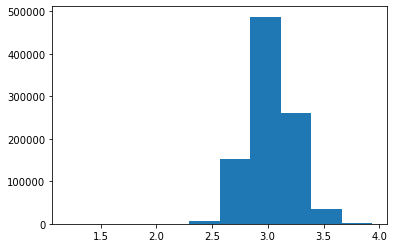

In [532]:
# 더블체크
print(DF_1['absi'].describe())
# absi 분포 확인하기
plt.hist(DF_1['absi'])
plt.show()

## III.스케일링
- DF_1 스케일링 없는 데이터
- DF_s 정규화한 데이터
- DF_n 표준화한 데이터

In [533]:
DF_1['fbs_L'] = np.digitize(DF_1['fbs'], [99,125,200,999])
DF_1['fbs_L2'] = np.digitize(DF_1['fbs'], [125])
DF_1['fbs_L3'] = np.digitize(DF_1['fbs'], [99])
DF_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943584 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      943584 non-null  float32
 1   age      943584 non-null  float32
 2   city     943584 non-null  float32
 3   ht       943584 non-null  float32
 4   wt       943584 non-null  float32
 5   waist    943584 non-null  float64
 6   sbp      943584 non-null  float64
 7   dbp      943584 non-null  float64
 8   fbs      943584 non-null  float64
 9   tchol    943584 non-null  float64
 10  tg       943584 non-null  float64
 11  hdl      943584 non-null  float64
 12  ldl      943584 non-null  float64
 13  hgb      943584 non-null  float64
 14  upro     943584 non-null  float64
 15  cr       943584 non-null  float64
 16  smoking  943584 non-null  float64
 17  alcohol  943584 non-null  float64
 18  bmi      943584 non-null  float32
 19  absi     943584 non-null  float64
 20  fbs_L    943584 non-null  

In [340]:
# 데이터 프레임 분리
sex = DF_1['sex']
age = DF_1['age']
city = DF_1['city']
ht = DF_1['ht']
wt = DF_1['wt']
waist = DF_1['waist']
sbp = DF_1['sbp']
dbp = DF_1['dbp']
fbs = DF_1['fbs']
tchol = DF_1['tchol']
tg = DF_1['tg']
hdl = DF_1['hdl']
ldl = DF_1['ldl']
hgb = DF_1['hgb']
upro = DF_1['upro']
cr = DF_1['cr']
smoking = DF_1['smoking']
alcohol = DF_1['alcohol']
bmi = DF_1['bmi']
absi = DF_1['absi']
fbs_L = DF_1['fbs_L']
fbs_L2 = DF_1['fbs_L2']
fbs_L3 = DF_1['fbs_L3']

In [341]:
# 스켈링 하지 말아야 될 변수들
DF_s = DF_1[['sex','age','city','upro','smoking','alcohol','fbs_L','fbs_L2','fbs_L3']]
DF_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968972 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      968972 non-null  float32
 1   age      968972 non-null  float32
 2   city     968972 non-null  float32
 3   upro     968972 non-null  float64
 4   smoking  968972 non-null  float64
 5   alcohol  968972 non-null  float64
 6   fbs_L    968972 non-null  int64  
 7   fbs_L2   968972 non-null  int64  
 8   fbs_L3   968972 non-null  int64  
dtypes: float32(3), float64(3), int64(3)
memory usage: 62.8 MB


In [342]:
# 스켈링 해야할 변수들
columns = ['ht','wt','waist','sbp','dbp','fbs','tchol','tg','hdl','ldl','hgb','cr','bmi','absi']

for i in columns :

    DF_s[i] = StandardScaler().fit_transform(DF_1[[i]])

DF_s.head()


,sex,age,city,upro,smoking,alcohol,fbs_L,fbs_L2,fbs_L3,ht,wt,waist,sbp,dbp,fbs,tchol,tg,hdl,ldl,hgb,cr,bmi,absi
0,1.0,8.0,43.0,1.0,1.0,1.0,1,0,1,0.845058,0.963583,0.942117,-0.153753,0.422866,-0.045264,-0.049532,-0.448949,-0.623715,0.379437,1.835358,0.751550,0.598412,0.349529
1,1.0,7.0,11.0,1.0,3.0,0.0,1,0,1,1.923367,1.367985,0.837153,0.545054,0.628695,0.255760,0.887137,-0.036316,-0.146683,1.022727,1.008005,0.250285,0.236324,0.247538
2,1.0,9.0,41.0,1.0,1.0,0.0,0,0,0,0.305903,0.963583,1.047081,-0.153753,-0.606275,-0.088267,-1.574964,-0.278205,-1.100748,-1.141065,1.008005,0.250285,1.057174,0.135553
3,1.0,11.0,48.0,1.0,1.0,0.0,0,0,0,1.384212,1.367985,1.047081,1.593266,1.143266,-0.217278,0.164564,-0.249747,1.284413,-0.263852,2.153571,1.252815,0.647515,0.228161
4,1.0,11.0,30.0,1.0,1.0,0.0,1,0,1,0.305903,-0.249623,-0.107520,1.104101,0.628695,0.040743,0.111040,-0.278205,0.262202,0.116273,-0.264846,-0.250979,-0.525895,0.444896


In [343]:
DF_n = DF_1[['sex','age','city','upro','smoking','alcohol','fbs_L','fbs_L2','fbs_L3']]
columns = ['ht','wt','waist','sbp','dbp','fbs','tchol','tg','hdl','ldl','hgb','cr','bmi','absi']

for i in columns :

    DF_n[i] = MinMaxScaler().fit_transform(DF_1[[i]])

DF_n.head()

,sex,age,city,upro,smoking,alcohol,fbs_L,fbs_L2,fbs_L3,ht,wt,waist,sbp,dbp,fbs,tchol,tg,hdl,ldl,hgb,cr,bmi,absi
0,1.0,8.0,43.0,1.0,1.0,1.0,1,0,1,0.666667,0.555556,0.597826,0.423729,0.547619,0.128920,0.480826,0.218750,0.376,0.459559,0.685535,0.500000,0.506653,0.692663
1,1.0,7.0,11.0,1.0,3.0,0.0,1,0,1,0.833333,0.611111,0.586957,0.508475,0.571429,0.141115,0.584071,0.288462,0.432,0.540441,0.603774,0.444444,0.459234,0.685246
2,1.0,9.0,41.0,1.0,1.0,0.0,0,0,0,0.583333,0.555556,0.608696,0.423729,0.428571,0.127178,0.312684,0.247596,0.320,0.268382,0.603774,0.444444,0.566733,0.677103
3,1.0,11.0,48.0,1.0,1.0,0.0,0,0,0,0.750000,0.611111,0.608696,0.635593,0.630952,0.121951,0.504425,0.252404,0.600,0.378676,0.716981,0.555556,0.513084,0.683837
4,1.0,11.0,30.0,1.0,1.0,0.0,1,0,1,0.583333,0.388889,0.489130,0.576271,0.571429,0.132404,0.498525,0.247596,0.480,0.426471,0.477987,0.388889,0.359413,0.699599


### 2) 스케일링 후 시각화

## IV.모델링 - 공복혈당 추론하기 - liner regression
- 적은수의 x : 나이, 성별, 키, 몸무게, 허리둘레, 음주, 흠연여부, (혹시 지역)
- 모든가능한 x : 17가지 


+ 1) 자가혈당 측정시 10~15%의 오차가 있다고 한다. (출처:삼성서울벼원 당뇨교육실)
+ 2) 이른 아침 공복 시에는 동맥과 정맥의 혈당 농도 차이는 10정도, 식후에는 20-25 차이가 있다 (네이버: 내과의사 너구리스)

In [40]:
DF_1['fbs'].describe()

count    968982.000000
mean        100.058702
std          23.333873
min          25.000000
25%          88.000000
50%          96.000000
75%         105.000000
max         852.000000
Name: fbs, dtype: float64

In [41]:
# 표준화한 데이터 체크
DF_s['fbs'].describe()

count    9.689820e+05
mean     7.777888e-17
std      1.000001e+00
min     -3.216729e+00
25%     -5.167898e-01
50%     -1.739404e-01
75%      2.117651e-01
max      3.222533e+01
Name: fbs, dtype: float64

### 1)일반 모델 - sklearn의 linearRegression

In [42]:
X = DF_s[['age', 'sex','city','ht','wt','waist','smoking','alcohol']]
y = DF_s['fbs']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (678287, 8) (678287,)
Test Data :  (290695, 8) (290695,)


In [43]:
fbs_model_1 = LinearRegression()
fbs_model_1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
y_hat = fbs_model_1.predict(X_test)

In [45]:
mse1 = mean_squared_error(y_test, y_hat)
np.sqrt(mse1)

0.957150352051771

### 2) 일반모델 확인 - statsmodels의 linearRegression

In [46]:
train_set, test_set = train_test_split(DF_s,
                                       test_size = 0.3,
                                       random_state = 2045)
train_set.shape, test_set.shape

((678287, 23), (290695, 23))

In [47]:
fbs_model_2 = smf.ols(formula = 'fbs ~ age + sex + city + ht + wt + waist + smoking + alcohol',
                      data = train_set).fit()

In [48]:
y_hat_2 = fbs_model_2.predict(test_set[['age', 'sex','city','ht','wt','waist','smoking','alcohol']])

In [49]:
mse2 = mean_squared_error(test_set.fbs, y_hat_2)
np.sqrt(mse2)


0.957150352051771

- 1)과2) 당현히 같고 0.96을 거꾸로 실제 값으로 돌려 계산하면 약 23 정도로 평균 100의 혈당치에서 23%의 오차가 남을 알 수 있다.
- std          24.102862 * mse = 23.2


### 2) 2) bmi 와 absi 를 추가해서 시행

In [50]:
train_set, test_set = train_test_split(DF_s,
                                       test_size = 0.3,
                                       random_state = 2045)
train_set.shape, test_set.shape

((678287, 23), (290695, 23))

In [51]:
fbs_model_2_2 = smf.ols(formula = 'fbs ~ age + sex + city + ht + wt + waist + smoking + alcohol+ bmi + absi',
                      data = train_set).fit()

In [52]:
y_hat_2_2 = fbs_model_2_2.predict(test_set[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']])

In [53]:
mse2_2 = mean_squared_error(test_set.fbs, y_hat_2_2)
np.sqrt(mse2_2)

0.9570733928106128

### bmi 와 absi 를 추가 했을시 향상한점이 보니나 충분하지 못하다.

### 3) 변수 다항화 - ABSI 변수 추가해서 
- MSE 작을수록 좋은 모델
- A Body Shape Index(ABSI) : ABSI waist/(BMI *2/3) * (ht *1/2) = A * waist X wt^2 : 약간 줄어들고,별차의 없음

In [54]:
fbs_model_3 = smf.ols(formula = 'fbs ~ age + sex + city + ht + wt + waist + smoking + alcohol + absi',
                      data = train_set).fit()

In [55]:
y_hat_3 = fbs_model_3.predict(test_set[['age', 'sex','ht','wt','city','waist','smoking','alcohol','absi']])

In [56]:
mse3 = mean_squared_error(test_set.fbs, y_hat_3)

print(np.sqrt(mse2))
print(np.sqrt(mse3))

0.957150352051771
0.9571148973034289


### 4) 변수 축소 - 변수 최소화 영향 안미치는 변수 제거

In [57]:
#변수를 최대한 줄인 모델
fbs_model_4 = smf.ols(formula = 'fbs ~ age + ht + wt + waist + smoking + alcohol ',
                      data = train_set).fit()

y_hat_4 = fbs_model_4.predict(test_set[['age', 'sex','ht','wt','city','waist','smoking','alcohol']])

mse4 = mean_squared_error(test_set.fbs, y_hat_4)

print(np.sqrt(mse2))
print(np.sqrt(mse4))

0.957150352051771
0.9575504620396806


### 5) 변수 다양화 - 내생각 변수 생성

In [58]:
fbs_model_5 = smf.ols(formula = 'fbs ~ age + ht + wt + waist + smoking + alcohol + wt/(waist*ht)',
                      data = train_set).fit()

y_hat_5 = fbs_model_5.predict(test_set[['age', 'sex','ht','wt','city','waist','smoking','alcohol']])

mse5 = mean_squared_error(test_set.fbs, y_hat_5)

print(np.sqrt(mse2))
print(np.sqrt(mse5))

0.957150352051771
0.9569678351373166


In [59]:
fbs_model_6 = smf.ols(formula = 'fbs ~ age + ht + wt + waist + smoking + alcohol + ht/(waist*wt)',
                      data = train_set).fit()

y_hat_6 = fbs_model_6.predict(test_set[['age', 'sex','ht','wt','city','waist','smoking','alcohol']])

mse6 = mean_squared_error(test_set.fbs, y_hat_6)

print(np.sqrt(mse2))
print(np.sqrt(mse6))

0.957150352051771
0.9572123497524354


### 6) 코드 다시 모아서 실행

In [345]:
# DF_a = DF
DF_a = DF_1
# DF_a = DF_s
# DF_a = DF_n
DF_a['fbs'].describe()

count    968972.000000
mean        100.052567
std          23.253971
min          25.000000
25%          88.000000
50%          96.000000
75%         105.000000
max         599.000000
Name: fbs, dtype: float64

In [61]:
X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs']

train_set, test_set = train_test_split(DF_a,
                                       test_size = 0.3,
                                       random_state = 2045)
train_set.shape, test_set.shape

fbs_model_a = smf.ols(formula = 'fbs ~ age + sex + city + ht + wt + waist + smoking + alcohol + bmi + absi',
                      data = train_set).fit()

y_hat_a = fbs_model_a.predict(test_set[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']])

mse_a = mean_squared_error(test_set.fbs, y_hat_a)
np.sqrt(mse_a)


0.02700388998923296

### - sns 으로 해보기

In [62]:
X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol', 'bmi', 'absi']]
y = DF_a['fbs']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

fbs_model_a = LinearRegression()
fbs_model_a.fit(X_train, y_train)

y_hat_a = fbs_model_a.predict(X_test)

mse_a = mean_squared_error(y_test, y_hat_a)
np.sqrt(mse_a)

Train Data :  (678287, 10) (678287,)
Test Data :  (290695, 10) (290695,)


0.027003889989232963

### 7)재미를 위해 x변수 중 하나를 y로, y를 x로

## V. 1) 모델링 - 공복혈당 추론하기 - Decision Tree
- 혈당수치가 연속적을 나와있어 분류모델을 적용하기 위해 레이블을 붙여 넣었음.
- -99 정상, 100-125 당뇨 전단계, 126이상 당뇨
- 만약 레이블이 없다면 최소단위


### 1) 1) 4그룹 분류 Decision Tree

In [63]:
DF_1['fbs_L'].value_counts()

0    580056
1    313798
2     65756
3      9372
Name: fbs_L, dtype: int64

In [64]:
X = DF_1[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_1['fbs_L']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (678287, 10) (678287,)
Test Data :  (290695, 10) (290695,)


In [65]:
Model_dt1 = DecisionTreeClassifier(random_state = 2045)
# Model_dt = DecisionTreeClassifier(max_depth = 3,
#                                   random_state = 2045)
Model_dt1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2045, splitter='best')

In [66]:
# 시간이 오래걸림
# graphviz.Source(export_graphviz(Model_dt1,
#                                 class_names = (['0', '1', '2']),
#                                 feature_names = (['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']),
#                                 filled = True))

In [67]:
y_hat1 = Model_dt1.predict(X_test)
y_hat1


array([0, 0, 0, ..., 2, 1, 1])

In [68]:
confusion_matrix(y_test, y_hat1)

array([[126198,  40911,   6092,    862],
       [ 59358,  28684,   5424,    737],
       [ 10777,   6906,   1721,    206],
       [  1597,    967,    219,     36]])

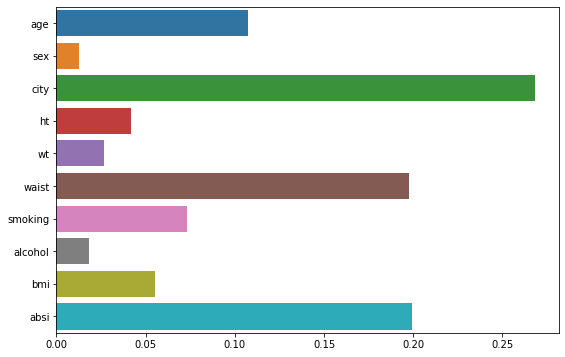

In [69]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt1.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 1) 2) 변수 최대한 줄여보기, 복합변수는 넣기

In [70]:
X = DF_1[['age', 'sex','smoking','alcohol','bmi','absi']]
y = DF_1['fbs_L']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)


Model_dt1_2 = DecisionTreeClassifier(random_state = 2045)
# Model_dt1_2 = DecisionTreeClassifier(max_depth = 3,
#                                   random_state = 2045)
Model_dt1_2.fit(X_train, y_train)


y_hat1_2 = Model_dt1_2.predict(X_test)
confusion_matrix(y_test, y_hat1_2)

Train Data :  (678287, 6) (678287,)
Test Data :  (290695, 6) (290695,)


array([[141274,  30056,   2431,    302],
       [ 66999,  24565,   2405,    234],
       [ 12044,   6646,    831,     89],
       [  1848,    835,    119,     17]])

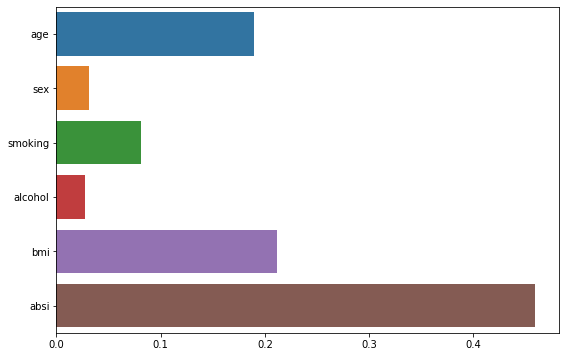

In [71]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt1_2.feature_importances_, ['age', 'sex','smoking','alcohol','bmi','absi'])
plt.show()

- 정상 분리는 많아졌으나 중요한 위험군과 당뇨 범위 정확도는 낮아짐

### 2) 1) 2그룹 분류 (fbs_L2): 일반+ 위험군 : 당뇨

In [72]:
DF_1['fbs_L2'].value_counts()

0    893854
1     75128
Name: fbs_L2, dtype: int64

In [73]:
X = DF_1[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_1['fbs_L2']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (678287, 10) (678287,)
Test Data :  (290695, 10) (290695,)


In [74]:
Model_dt_2 = DecisionTreeClassifier(random_state = 2045)
# Model_dt_2 = DecisionTreeClassifier(max_depth = 2,
#                                   random_state = 2045)
Model_dt_2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2045, splitter='best')

In [75]:
y_hat2 = Model_dt_2.predict(X_test)
y_hat2


array([0, 0, 0, ..., 1, 0, 0])

In [76]:
# 시간이 많이 걸림
# graphviz.Source(export_graphviz(Model_dt_2,
#                                 class_names = (['0', '1']),
#                                 feature_names = (['age', 'sex','city','ht','wt','waist','smoking','alcohol']),
#                                 filled = True))

In [77]:
print(confusion_matrix(y_test, y_hat2))
print('accuray : ' , accuracy_score(y_test, y_hat2))
print('prescision :' , precision_score(y_test, y_hat2))
print('recall :' , recall_score(y_test, y_hat2))

[[254302  13964]
 [ 20149   2280]]
accuray :  0.8826502003818435
prescision : 0.1403595173602561
recall : 0.10165410852021936


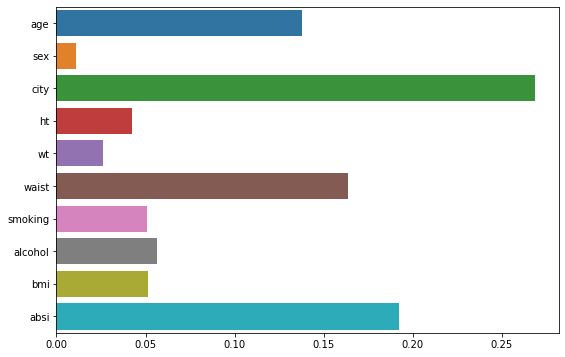

In [78]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt_2.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 2) 2) 2그룹으로 분류 (fbs_L3) : 일반 : 위험+당뇨

In [79]:
DF_1['fbs_L3'].value_counts()

0    580056
1    388926
Name: fbs_L3, dtype: int64

In [80]:
X = DF_1[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_1['fbs_L3']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (678287, 10) (678287,)
Test Data :  (290695, 10) (290695,)


In [81]:
Model_dt_2_2 = DecisionTreeClassifier(random_state = 2045)
# Model_dt_2_2 = DecisionTreeClassifier(max_depth = 2,
#                                   random_state = 2045)
Model_dt_2_2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2045, splitter='best')

In [82]:
y_hat2_2 = Model_dt_2_2.predict(X_test)

print(confusion_matrix(y_test, y_hat2_2))
print('accuray : ' , accuracy_score(y_test, y_hat2_2))
print('prescision :' , precision_score(y_test, y_hat2_2))
print('recall :' , recall_score(y_test, y_hat2_2))

[[123661  50402]
 [ 69229  47403]]
accuray :  0.5884655738832797
prescision : 0.48466847298195387
recall : 0.40643219699567873


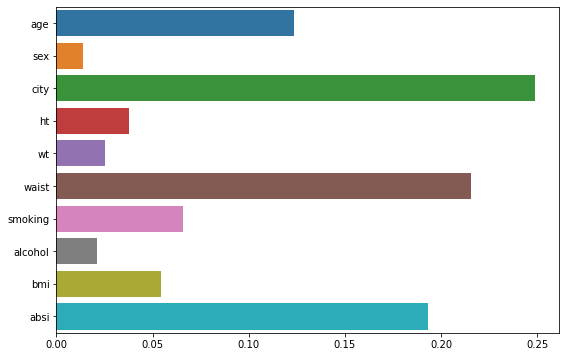

In [83]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt_2_2.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 3) 결론
- DT 로 혈당을 측정할때 가지고 있는 변수만 사용하면 높은 정확도를 낼 수 없다
- 당뇨환자만 추출하는 것이 목적이라 정상+위험: 당뇨 그룹으로 나누워도 측정하기가 힘들었다
- 고혈압 판정으로 약복용하여 위험군 수준으로 혈당을 나추었다 가정하여. 정상:위험+당뇨 군으로 나누어 하더라도 정확도 가 높지 않았다

## V. 2) 모델링 - 공복혈당 추론하기 - Decision Tree - 연속형 데이터로

In [300]:
# DF_a = DF
# DF_a = DF_1
# DF_a = DF_s
DF_a = DF_n
DF_a['fbs'].describe()

count    968972.000000
mean          0.130754
std           0.040512
min           0.000000
25%           0.109756
50%           0.123693
75%           0.139373
max           1.000000
Name: fbs, dtype: float64

In [301]:
X = DF_a[['age', 'sex','ht','city','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (678280, 10) (678280,)
Test Data :  (290692, 10) (290692,)


In [302]:
Model_dt_a = DecisionTreeRegressor(random_state = 2045)

Model_dt_a.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=2045, splitter='best')

In [303]:
y_hat_dt_a = Model_dt_a.predict(X_test)
mse_dt_a = mean_squared_error(y_test, y_hat_dt_a)
print(mse_dt_a)

0.0027709626438465196


- 도시 변수를 넣었을때 너무 높게 나옴 

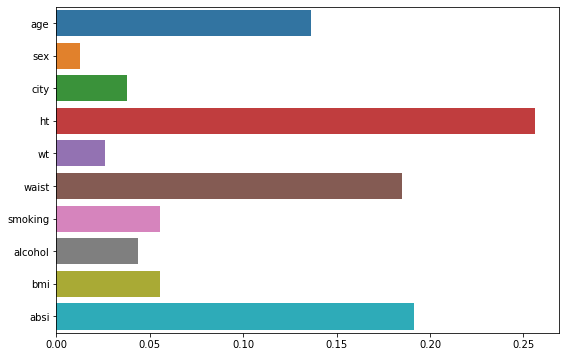

In [304]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt_a.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

## VI.모델링 - 공복혈당 추론하기 - Decision Tree - 연령대별
- 만약 머신이 약 처방받은 사람의 특징때문에 

## VII. 1) 모델링 - 공복혈당 추론하기 - Random forest

- 매우 중요한 팩터들만 추려내보기

In [89]:
# 7분정도 소요
# DF_t = DF_1[['age','bmi','absi','fbs_L3']]
# sns.pairplot(hue= 'fbs_L3',data = DF_t)
# plt.show()

In [90]:
# 14분 소요
# DF_t2 = DF_1[['age','bmi','absi','city','fbs_L3']]
# sns.pairplot(hue= 'fbs_L3',data = DF_t2)
# plt.show()

### 1) 기본 random_state

In [347]:
# 데이터 프레임 변경용
# DF_a = DF
DF_a = DF_1
# DF_a = DF_s
# DF_a = DF_n
DF_a['fbs'].describe()

count    968972.000000
mean        100.052567
std          23.253971
min          25.000000
25%          88.000000
50%          96.000000
75%         105.000000
max         599.000000
Name: fbs, dtype: float64

In [348]:
X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs_L']

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (678280, 10) (678280,)
Test Data :  (290692, 10) (290692,)


In [350]:
Model_rf1 = RandomForestClassifier(n_estimators = 10,
                                  max_features = 3,
                                  random_state = 2045,
                                  n_jobs = -1)
Model_rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=2045, verbose=0,
                       warm_start=False)

In [351]:
y_hat_rf1 = Model_rf1.predict(X_test)

In [352]:
print(confusion_matrix(y_test, y_hat_rf1))
print(accuracy_score(y_test, y_hat_rf1))

[[128235  40018   4780    546]
 [ 59461  30052   4393    440]
 [ 10685   7687   1378    145]
 [  1661   1033    156     22]]
0.5493340029997386


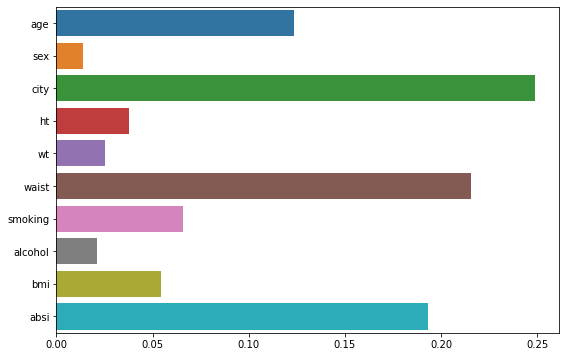

In [353]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt_2_2.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 2) 기본 L2,L3 1)과 같은 방식

In [98]:
X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs_L3']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_rf2 = RandomForestClassifier(n_estimators = 10,
                                  max_features = 3,
                                  random_state = 2045,
                                  n_jobs = -1)
Model_rf2.fit(X_train, y_train)

y_hat_rf2 = Model_rf2.predict(X_test)

print(confusion_matrix(y_test, y_hat_rf2))
print('accuray : ' , accuracy_score(y_test, y_hat_rf2))
print('prescision :' , precision_score(y_test, y_hat_rf2))
print('recall :' , recall_score(y_test, y_hat_rf2))

Train Data :  (678287, 10) (678287,)
Test Data :  (290695, 10) (290695,)
[[122947  51116]
 [ 65796  50836]]
accuray :  0.5978190199349834
prescision : 0.49862680477087257
recall : 0.435866657521092


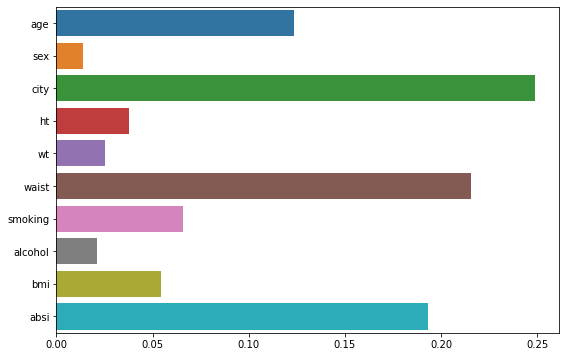

In [99]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt_2_2.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

In [100]:
X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs_L3']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_rf3 = RandomForestClassifier(n_estimators = 10,
                                  max_features = 3,
                                  random_state = 2045,
                                  n_jobs = -1)
Model_rf3.fit(X_train, y_train)

y_hat_rf3 = Model_rf3.predict(X_test)

print(confusion_matrix(y_test, y_hat_rf3))
print('accuray : ' , accuracy_score(y_test, y_hat_rf3))
print('prescision :' , precision_score(y_test, y_hat_rf3))
print('recall :' , recall_score(y_test, y_hat_rf3))

Train Data :  (678287, 10) (678287,)
Test Data :  (290695, 10) (290695,)
[[122947  51116]
 [ 65796  50836]]
accuray :  0.5978190199349834
prescision : 0.49862680477087257
recall : 0.435866657521092


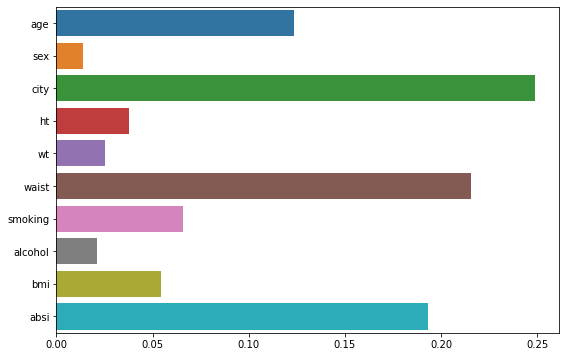

In [101]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt_2_2.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 3) GridSearch

In [102]:
# params = {'n_estimators':[10, 30, 50, 70],
#           'max_features':[ 2, 3, 4],
#           # 'max_depth':[1, 2, 3, 4, 5],
#           'random_state':[2045]}

In [103]:
# grid_cv = GridSearchCV(Model_rf3,
#                        param_grid = params,
#                        scoring = 'recall',
#                        cv = KFold(n_splits = 5,
#                                   random_state = 2045),
#                        refit = True,
#                        n_jobs = -1)

In [104]:
# 48 분만에 포기
# grid_cv.fit(X_train, y_train)

In [105]:
# print(grid_cv.best_score_ )
# print(grid_cv.best_params_)

In [106]:
# Model_rf3_best = grid_cv.best_estimator_
# y_hat_rf3_best = Model_rf3_best.predict(X_test)

In [107]:
# print(confusion_matrix(y_test, y_hat_rf3_best))
# print('accuray : ' , accuracy_score(y_test, y_hat_rf3_best))
# print('prescision :' , precision_score(y_test, y_hat_rf3_best))
# print('recall :' , recall_score(y_test, y_hat_rf3_best))

### 3) 2) for 문으로 GridSearch 대신

In [108]:
# 20분 소요
startT = time.time()

X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs_L3']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

n_estimators = [10, 30, 50, 70]
max_features = [1, 2, 3, 4]
max_depth = [1, 2, 3, 4, 5]

Model_result=[]

for i in n_estimators :
  for j in max_features :
    for k in max_depth:

      Model_rf3 = RandomForestClassifier(n_estimators = i, 
                                              max_features = j,
                                              max_depth = k, 
                                              random_state = 2045,
                                              n_jobs=-1)
      
      Model_rf3.fit(X_train, y_train)

      y_hat_rf3 = Model_rf3.predict(X_test)
      print('n_estimators :' ,i, 'max_features :', j, 'max_depth :', k)
      print(confusion_matrix(y_test, y_hat_rf3))
      print('accuray : ' , accuracy_score(y_test, y_hat_rf3))
      print('prescision :' , precision_score(y_test, y_hat_rf3))
      print('recall :' , recall_score(y_test, y_hat_rf3))

      a = accuracy_score(y_test, y_hat_rf3)
      b = precision_score(y_test, y_hat_rf3)
      c = recall_score(y_test, y_hat_rf3)
      data = [i,j,k,a,b,c]
      Model_result.append(data)
Model_GS_L3 = pd.DataFrame(Model_result)
Model_GS_L3.columns = ['n_estimators','max_feature','max_depth','accuray','prescision','recall']


print('time : ', time.time() - startT )

Train Data :  (678287, 10) (678287,)
Test Data :  (290695, 10) (290695,)
n_estimators : 10 max_features : 1 max_depth : 1
[[174063      0]
 [116632      0]]
accuray :  0.5987822287965049
prescision : 0.0
recall : 0.0
n_estimators : 10 max_features : 1 max_depth : 2
[[166251   7812]
 [103247  13385]]
accuray :  0.6179535251724316
prescision : 0.6314572816908053
recall : 0.11476267233692297
n_estimators : 10 max_features : 1 max_depth : 3
[[157586  16477]
 [ 91469  25163]]
accuray :  0.628662343693562
prescision : 0.6042987512007685
recall : 0.2157469648124014
n_estimators : 10 max_features : 1 max_depth : 4
[[154936  19127]
 [ 87231  29401]]
accuray :  0.6341251139510483
prescision : 0.6058564127926146
recall : 0.2520834762329378
n_estimators : 10 max_features : 1 max_depth : 5
[[150170  23893]
 [ 80811  35821]]
accuray :  0.639814926297322
prescision : 0.5998760759620859
recall : 0.3071284038685781
n_estimators : 10 max_features : 2 max_depth : 1
[[174063      0]
 [116632      0]]
accu

KeyboardInterrupt: ignored

In [ ]:
Model_GS_L3.info()

In [ ]:
Model_GS_L3['recall'].describe()

In [ ]:
Model_GS_L3['prescision'].describe()

In [ ]:
# 20분 소요
X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs_L2']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

n_estimators = [10, 30, 50, 70]
max_features = [1, 2, 3, 4]
max_depth = [1, 2, 3, 4, 5]

Model_result=[]

for i in n_estimators :
  for j in max_features :
    for k in max_depth:

      Model_rf3 = RandomForestClassifier(n_estimators = i, 
                                              max_features = j,
                                              max_depth = k, 
                                              random_state = 2045,
                                              n_jobs=-1)
      
      Model_rf3.fit(X_train, y_train)

      y_hat_rf3 = Model_rf3.predict(X_test)
      print('n_estimators :' ,i, 'max_features :', j, 'max_depth :', k)
      print(confusion_matrix(y_test, y_hat_rf3))
      print('accuray : ' , accuracy_score(y_test, y_hat_rf3))
      print('prescision :' , precision_score(y_test, y_hat_rf3))
      print('recall :' , recall_score(y_test, y_hat_rf3))

      a = accuracy_score(y_test, y_hat_rf3)
      b = precision_score(y_test, y_hat_rf3)
      c = recall_score(y_test, y_hat_rf3)
      data = [i,j,k,a,b,c]
      Model_result.append(data)
Model_GS_L2 = pd.DataFrame(Model_result)
Model_GS_L2.columns = ['n_estimators','max_feature','max_depth','accuray','prescision','recall']

In [ ]:
Model_GS_L2['recall'].describe()

In [ ]:
Model_GS_L2['prescision'].describe()

## VII. 2) 모델링 - 공복혈당 추론하기 - Random Forest - 연속형 데이터

### 1) 일반 Random Forest

In [401]:
DF_a = DF
# DF_a = DF_1
# DF_a = DF_s
# DF_a = DF_n
DF_a['fbs'].describe()

count    991608.000000
mean        100.424266
std          24.178758
min          25.000000
25%          88.000000
50%          96.000000
75%         105.000000
max         852.000000
Name: fbs, dtype: float64

In [402]:
X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs']

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (694125, 10) (694125,)
Test Data :  (297483, 10) (297483,)


In [369]:
# Model_rf_a = RandomForestRegressor(n_estimators = 10,
#                                   max_features = 3,
#                                   random_state = 2045,
#                                   n_jobs = -1)
# Model_rf_a.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=2045, verbose=0, warm_start=False)

In [404]:
Model_rf_a = RandomForestRegressor(n_estimators = 200,
                                   max_features = 4,
                                   max_depth = 9,
                                   random_state = 2045,
                                   n_jobs = -1)
Model_rf_a.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=2045, verbose=0, warm_start=False)

In [405]:
y_hat_rf_a = Model_rf_a.predict(X_test)
mse_rf_a = mean_squared_error(y_test, y_hat_rf_a)
print(mse_rf_a)

539.9643572035493


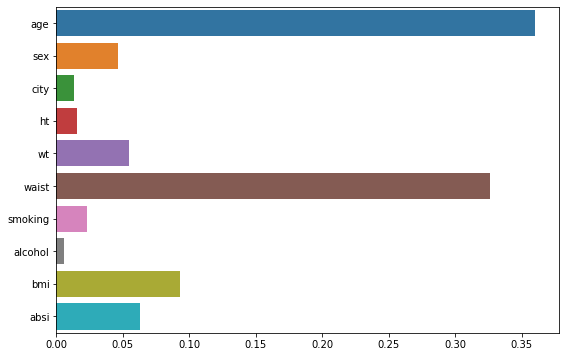

In [406]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_rf_a.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 2) for 문 GridSearch

In [ ]:
# DF_a = DF
# DF_a = DF_1
DF_a = DF_s
# DF_a = DF_n

In [ ]:
# 9분 소요
X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

n_estimators = [10, 30, 50, 70]
max_features = [1, 2, 3, 4]
max_depth = [1, 2, 3, 4, 5]

Model_result=[]

for i in n_estimators :
  for j in max_features :
    for k in max_depth:

      Model_rf_a = RandomForestRegressor(n_estimators = i, 
                                              max_features = j,
                                              max_depth = k, 
                                              random_state = 2045,
                                              n_jobs=-1)
      
      Model_rf_a.fit(X_train, y_train)

      y_hat_rf_a = Model_rf_a.predict(X_test)
      mse_rf_a = mean_squared_error(y_test, y_hat_rf_a)

      print('n_estimators :' ,i, 'max_features :', j, 'max_depth :', k)
      print('mse : ' , mse_rf_a)


      a = mean_squared_error(y_test, y_hat_rf_a)
      data = [i,j,k,a,]
      Model_result.append(data)
Model_GS_a = pd.DataFrame(Model_result)
Model_GS_a.columns = ['n_estimators','max_feature','max_depth','mse']

In [ ]:
#데이터 프레임 저장
Model_GS_a.to_csv('c:/My_data/health_care/Random_Forest_(for)GS_a.csv')
#데이터 프레임 불러오기
Model_GS_a = pd.read_csv('c:/My_data/health_care/Random_Forest_(for)GS_a.csv', encoding='cp949')

In [ ]:
Model_GS_a['mse'].describe()

In [ ]:
maxs = Model_GS_a.loc[Model_GS_a['mse'].idxmax()]
print('max : ' , maxs)
mins = Model_GS_a.loc[Model_GS_a['mse'].idxmin()]
print('min : ' , mins)

In [373]:
# 1시간 20분 소요
startT = time.time()

X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

n_estimators = [10, 50, 100, 150, 200]
max_features = [3, 4, 5]
max_depth = [9, 10, 11, 12, 13]

Model_result=[]

for i in n_estimators :
  for j in max_features :
    for k in max_depth:

      Model_rf_a = RandomForestRegressor(n_estimators = i, 
                                              max_features = j,
                                              max_depth = k, 
                                              random_state = 2045,
                                              n_jobs=-1)
      
      Model_rf_a.fit(X_train, y_train)

      y_hat_rf_a = Model_rf_a.predict(X_test)
      mse_rf_a = mean_squared_error(y_test, y_hat_rf_a)

      print('n_estimators :' ,i, 'max_features :', j, 'max_depth :', k)
      print('mse : ' , mse_rf_a)


      a = mean_squared_error(y_test, y_hat_rf_a)
      data = [i,j,k,a,]
      Model_result.append(data)
Model_GS_a2 = pd.DataFrame(Model_result)
Model_GS_a2.columns = ['n_estimators','max_feature','max_depth','mse']

print('time : ', time.time() - startT )

Train Data :  (678280, 10) (678280,)
Test Data :  (290692, 10) (290692,)
n_estimators : 10 max_features : 3 max_depth : 9
mse :  0.0015151103782945054
n_estimators : 10 max_features : 3 max_depth : 10
mse :  0.0015159504885458896
n_estimators : 10 max_features : 3 max_depth : 11
mse :  0.0015184098123660747
n_estimators : 10 max_features : 3 max_depth : 12
mse :  0.0015212445502149246
n_estimators : 10 max_features : 3 max_depth : 13
mse :  0.0015271498385474574
n_estimators : 10 max_features : 4 max_depth : 9
mse :  0.0015139212834629297
n_estimators : 10 max_features : 4 max_depth : 10
mse :  0.0015176096712061341
n_estimators : 10 max_features : 4 max_depth : 11
mse :  0.0015191693357225183
n_estimators : 10 max_features : 4 max_depth : 12
mse :  0.001523968652823406
n_estimators : 10 max_features : 4 max_depth : 13
mse :  0.0015300214882573977
n_estimators : 10 max_features : 5 max_depth : 9
mse :  0.00151569999648865
n_estimators : 10 max_features : 5 max_depth : 10
mse :  0.00151

In [376]:
#데이터 프레임 저장
Model_GS_a2.to_csv('c:/My_data/health_care/Random_Forest_(for)GS_a2(600).csv')
#데이터 프레임 불러오기
Model_GS_a2 = pd.read_csv('c:/My_data/health_care/Random_Forest_(for)GS_a2(600).csv', encoding='cp949')

FileNotFoundError: ignored

In [377]:
Model_GS_a2.to_csv('c:/My_data/health_care/Random_Forest_(for)GS_a2(600).csv')

FileNotFoundError: ignored

In [378]:
Model_GS_a2['mse'].describe()

count    75.000000
mean      0.001517
std       0.000004
min       0.001513
25%       0.001514
50%       0.001515
75%       0.001518
max       0.001530
Name: mse, dtype: float64

In [379]:
maxs = Model_GS_a2.loc[Model_GS_a2['mse'].idxmax()]
print('max : ' , maxs)
mins = Model_GS_a2.loc[Model_GS_a2['mse'].idxmin()]
print('min : ' , mins)

max :  n_estimators    10.00000
max_feature      5.00000
max_depth       13.00000
mse              0.00153
Name: 14, dtype: float64
min :  n_estimators    200.000000
max_feature       4.000000
max_depth         9.000000
mse               0.001513
Name: 65, dtype: float64


In [ ]:
# 1시간 20분 소요
startT = time.time()

X = DF_a[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_a['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

n_estimators = [200, 800]
max_features = [3, 4, 5, 6]
max_depth = [9,10,11, 12]

Model_result=[]

for i in n_estimators :
  for j in max_features :
    for k in max_depth:

      Model_rf_a = RandomForestRegressor(n_estimators = i, 
                                              max_features = j,
                                              max_depth = k, 
                                              random_state = 2045,
                                              n_jobs=-1)
      
      Model_rf_a.fit(X_train, y_train)

      y_hat_rf_a = Model_rf_a.predict(X_test)
      mse_rf_a = mean_squared_error(y_test, y_hat_rf_a)

      print('n_estimators :' ,i, 'max_features :', j, 'max_depth :', k)
      print('mse : ' , mse_rf_a)


      a = mean_squared_error(y_test, y_hat_rf_a)
      data = [i,j,k,a,]
      Model_result.append(data)
Model_GS_a2 = pd.DataFrame(Model_result)
Model_GS_a2.columns = ['n_estimators','max_feature','max_depth','mse']

print('time : ', time.time() - startT )